# Model Predictive Control in MuJoCo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer as viewer
import mediapy as media

## Model MPC

In [3]:
class ModelPredictiveControl(object):
    
    # A,B,C - system matrices
    # f -  prediction horizon
    # v  - control horizon
    # W3 - input weight matrix
    # W4 - prediction weight matrix
    # x0 - initial state of the system
    # desiredControlTrajectoryTotal - total desired control trajectory
    #                               later on, we will take segments of this
    #                               desired state trajectory
    
    def __init__(self,A,B,C,f,v,W3,W4,x0,desiredControlTrajectoryTotal):
        
        # initialize variables
        self.A=A 
        self.B=B
        self.C=C
        self.f=f
        self.v=v
        self.W3=W3 
        self.W4=W4
        self.desiredControlTrajectoryTotal=desiredControlTrajectoryTotal
        
        # dimensions of the matrices
        
        self.n=A.shape[0]
        self.r=C.shape[0]
        self.m=B.shape[1]        
                
               
        # this variable is used to track the current time step k of the controller
        # after every calculation of the control inpu, this variables is incremented for +1 
        self.currentTimeStep=0
        
        # we store the state vectors of the controlled state trajectory
        self.states=[]
        self.states.append(x0)
        
        # we store the computed inputs 
        self.inputs=[]
        
        # we store the output vectors of the controlled state trajectory
        self.outputs=[]
        
        
        # form the lifted system matrices and vectors
        # the gain matrix is used to compute the solution 
        # here we pre-compute it to save computational time
        self.O, self.M, self.gainMatrix = self.formLiftedMatrices()
        
    
    # this function forms the lifted matrices O and M, as well as the 
    # the gain matrix of the control algorithm
    # and returns them 
    def formLiftedMatrices(self):
        f=self.f
        v=self.v
        r=self.r
        n=self.n
        m=self.m
        A=self.A
        B=self.B
        C=self.C
        
        # lifted matrix O
        O=np.zeros(shape=(f*r,n))

        for i in range(f):
            if (i == 0):
                powA=A;
            else:
                powA=np.matmul(powA,A)
            O[i*r:(i+1)*r,:]=np.matmul(C,powA)

        # lifted matrix M        
        M=np.zeros(shape=(f*r,v*m))
    
        for i in range(f):
            # until the control horizon
            if (i<v):
                for j in range(i+1):
                    if (j == 0):
                        powA=np.eye(n,n);
                    else:
                        powA=np.matmul(powA,A)
                    M[i*r:(i+1)*r,(i-j)*m:(i-j+1)*m]=np.matmul(C,np.matmul(powA,B))
            
            # from control horizon until the prediction horizon
            else:
                for j in range(v):
                    # here we form the last entry
                    if j==0:
                        sumLast=np.zeros(shape=(n,n))
                        for s in range(i-v+2):
                            if (s == 0):
                                powA=np.eye(n,n);
                            else:
                                powA=np.matmul(powA,A)
                            sumLast=sumLast+powA
                        M[i*r:(i+1)*r,(v-1)*m:(v)*m]=np.matmul(C,np.matmul(sumLast,B))
                    else:
                        powA=np.matmul(powA,A)
                        M[i*r:(i+1)*r,(v-1-j)*m:(v-j)*m]=np.matmul(C,np.matmul(powA,B))
        
        
        tmp1=np.matmul(M.T,np.matmul(self.W4,M))
        tmp2=np.linalg.inv(tmp1+self.W3)
        gainMatrix=np.matmul(tmp2,np.matmul(M.T,self.W4))
        
        
        return O,M,gainMatrix
    
    # this function propagates the dynamics
    # x_{k+1}=Ax_{k}+Bu_{k}
    
    def propagateDynamics(self,controlInput,state):

        xkp1=np.zeros(shape=(self.n,1))
        yk=np.zeros(shape=(self.r,1))
        xkp1=np.matmul(self.A,state)+np.matmul(self.B,controlInput)
        yk=np.matmul(self.C,state)
        
        return xkp1,yk
        
    # this function computes the control inputs, applies them to the system 
    # by calling the propagateDynamics() function and appends the lists
    # that store the inputs, outputs, states
    def computeControlInputs(self):
                
        # extract the segment of the desired control trajectory
        desiredControlTrajectory=self.desiredControlTrajectoryTotal[self.currentTimeStep:self.currentTimeStep+self.f,:]

        # compute the vector s
        vectorS=desiredControlTrajectory-np.matmul(self.O,self.states[self.currentTimeStep])
       
        # compute the control sequence
        inputSequenceComputed=np.matmul(self.gainMatrix,vectorS)
        inputApplied=np.zeros(shape=(1,1))
        inputApplied[0,0]=inputSequenceComputed[0,0]
        
        # compute the next state and output
        state_kp1,output_k=self.propagateDynamics(inputApplied,self.states[self.currentTimeStep])
        
        # append the lists
        self.states.append(state_kp1)
        self.outputs.append(output_k)
        self.inputs.append(inputApplied)
        # increment the time step
        self.currentTimeStep=self.currentTimeStep+1
        

## Load Model

In [3]:
# load model
xml = "../mujoco_menagerie/universal_robots_ur5e/scene.xml"
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

## Render random noise

In [3]:
DURATION  = 5   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1

# Initialize the robot pose.
mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
    # Set control vector.
    data.ctrl = np.random.randn(model.nu)
    
    # Step the simulation.
    mujoco.mj_step(model, data)    

    # Render and save frames.
    if len(frames) < data.time * FRAMERATE:
        # # Set the lookat point to the humanoid's center of mass.
        # camera.lookat = data.body('torso').subtree_com
        
        renderer.update_scene(data, camera)
        pixels = renderer.render()
        frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

## Define model

""

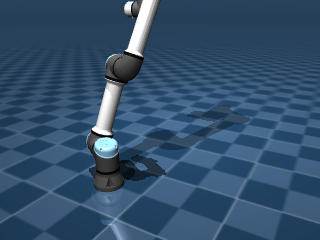

In [12]:
# mujoco.mj_resetDataKeyframe(model, data, 1)
# mujoco.mj_forward(model, data)
# data.qacc = 0  # Assert that there is no the acceleration.
# mujoco.mj_inverse(model, data)
# print(data.qfrc_inverse)

# method that give the end effector position and return the qpos
def inverse_kinematics(model, data, body_id, desire_point, delta_point, jacp, jacr):
    mujoco.mj_forward(model, data) # compute forward kinematics
    mujoco.mj_jac(model, data, jacp, jacr, desire_point, body_id) # calculate jacobians
    
    delta_pos = np.linalg.pinv(jacp) @ delta_point #calculate deltas of position
    data.qpos += delta_pos #update actuators position
        
# Init variables.
body_id = 6
x, dx = 2, 0.5
y, dy = 10, 0.5
z, dz = 8, 0.5
desire_point = np.array([x, y, z])
delta_point = np.array([dx, dy, dz])
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian

# Make a new camera position #TODO:update this position to one better.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1

#give a desire point
mujoco.mj_resetDataKeyframe(model, data, 1)
inverse_kinematics(model, data, body_id, desire_point, delta_point,jacp, jacr)

# show position
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [7]:
nu = model.nu # number of actuators
nv = model.nv  # number of degree of freedoms.
nsensordata = model.nsensordata

# set initial state and control
mujoco.mj_resetData(model, data)
# data.ctrl = ctrl0
# data.qpos = qpos0

# define the continuous-time system matrices A, B, C
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
C = np.zeros((nsensordata, 2*nv))

epsilon = 1e-6
flg_centered = False

mujoco.mjd_transitionFD(model, data, epsilon, flg_centered, A, B, C, None)

# r=1; m=1 # number of inputs and outputs
# n= 4 # state dimension